In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import scikit_posthocs as sp

run_type = "dry"
#run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"DR_lifelong":"red", "AL_lifelong":"dodgerblue", 
           "AL_DR16M":"teal", "AL_DR20M":"gold", "Food":"brown", "AL_DR12M":"magenta"}
path = "./MPI/16S_final/F1_longitudinal/analysis/intermediate_April2023/"

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [11]:
# We have alpha values from estimate richness in R
# Read alpha diversity dataframe
a = pd.read_csv(path + "alpha_values_20230424.csv", sep = ";")
a["Sample_ID"] = a.index.str.replace(".", "-")
a.reset_index(inplace = True)
a = a.drop(columns = ["index"])
# Read metadata file and format
me = pd.read_csv("./MPI/16S_final/F1_longitudinal/metadata/metadata_ready2.csv", sep = ";")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_58819/328939247.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  a["Sample_ID"] = a.index.str.replace(".", "-")


In [13]:
mea = pd.merge(me.loc[:, ["Sample_ID", "Months", 
        "Treatment", "Cage_No"]], a, on = "Sample_ID", how = "inner")

In [15]:
def boxplot_alpha_all(text, mea):
    fig, ax = plt.subplots(figsize = (13, 5))
    hue_order = ["AL_lifelong", "DR_lifelong", "AL_DR16M"]
    ax = sns.boxplot(data = mea, y = text, x = "Months", hue = "Treatment", 
               palette = palette, hue_order = hue_order, showfliers = False, ax = ax)
    ax = sns.swarmplot(data = mea, y = text, x = "Months", hue = "Treatment",
                      dodge = True, color = ".25", ax = ax, hue_order = hue_order)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:4], labels[:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 18)


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #for line in leg.get_lines():
    #    line.set_linewidth(3.5)
    ax.tick_params(axis = "x", labelsize=18)
    ax.tick_params(axis = "y", labelsize=18)
    plt.ylabel("Alpha diversity [{}]".format(text), fontsize = 20)
    plt.xlabel("Age [Months]", fontsize = 20)
    plt.tight_layout()
    matplotlib.rcParams['pdf.fonttype'] = 42

    if run_type != "dry":
        plt.savefig("{}Alpha_boxplot_{}_allDiets_{}.pdf".format(path, text, new_day))
    else:
        plt.show()

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


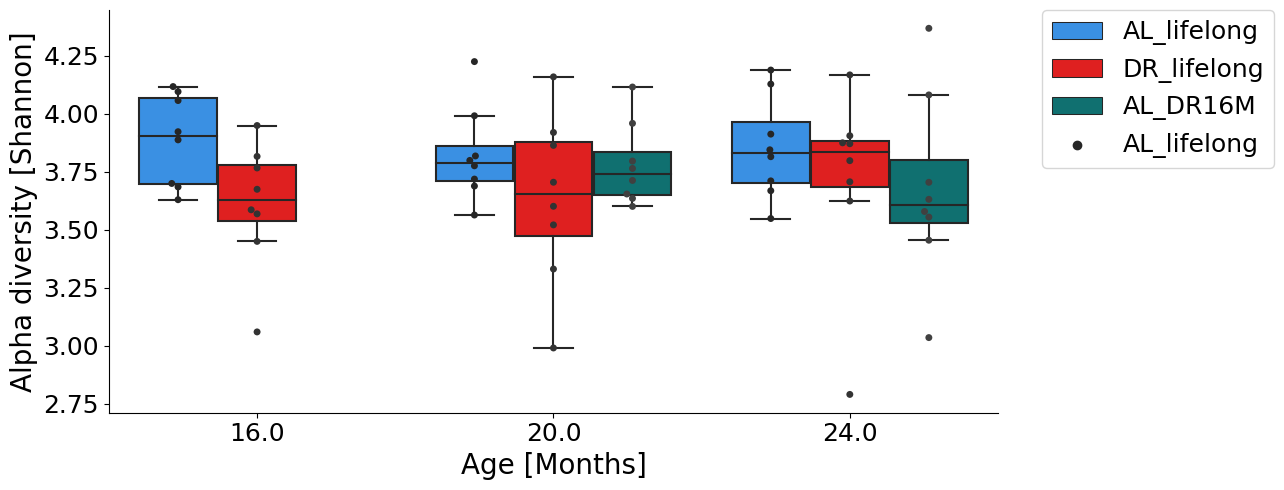

In [16]:
boxplot_alpha_all("Shannon", mea)

In [17]:
for method in ["Observed", "Shannon", "Simpson"]:
    
    print("Anova comparing treatments: {}\n".format(method))

    test = mea[mea["Treatment"].isin(["AL_lifelong", "DR_lifelong"])]
    model = ols(f"{method} ~ C(Months) + C(Treatment) + C(Months):C(Treatment)", data = test).fit()
    display(sm.stats.anova_lm(model, typ=2))

Anova comparing treatments: Observed



,sum_sq,df,F,PR(>F)
C(Months),2562.666667,2.0,0.821393,0.446759
C(Treatment),420.083333,1.0,0.269292,0.606531
C(Months):C(Treatment),921.166667,2.0,0.295255,0.745874
Residual,65518.000000,42.0,NaN,NaN


Anova comparing treatments: Shannon



,sum_sq,df,F,PR(>F)
C(Months),0.025188,2.0,0.151082,0.860242
C(Treatment),0.476659,1.0,5.718074,0.021348
C(Months):C(Treatment),0.041900,2.0,0.251318,0.778936
Residual,3.501123,42.0,NaN,NaN


Anova comparing treatments: Simpson



,sum_sq,df,F,PR(>F)
C(Months),0.000003,2.0,0.002565,0.997438
C(Treatment),0.001217,1.0,2.078374,0.156815
C(Months):C(Treatment),0.000149,2.0,0.126996,0.881074
Residual,0.024597,42.0,NaN,NaN


In [19]:
# Statistics
print("//K-W BETWEEN TREATMENTS WITHIN TIMEPOINTS//")
# Check ANOVA between treatments within timepoints
pd.set_option("display.max_rows", None, "display.max_columns", None)
for e in [16, 20, 24]:
    for method in ["Observed", "Shannon", "Simpson"]:
    
        print("Kruskall-Wallis comparing treatments at {} Months {}\n".format(e, method))

        test = mea[mea["Months"] == e]

        print(stats.kruskal(test[method].to_list(), test["Treatment"].to_list()))
        print("Mann-Whitney comparing treatments at {} Months {}\n".format(e, method))
        print(sp.posthoc_dunn(test, val_col = method, group_col = "Treatment", p_adjust = 'bonferroni'))

//K-W BETWEEN TREATMENTS WITHIN TIMEPOINTS//
Kruskall-Wallis comparing treatments at 16 Months Observed

KruskalResult(statistic=24.021188043889527, pvalue=9.52813930083919e-07)
Mann-Whitney comparing treatments at 16 Months Observed

             AL_lifelong  DR_lifelong
AL_lifelong     1.000000     0.874643
DR_lifelong     0.874643     1.000000
Kruskall-Wallis comparing treatments at 16 Months Shannon

KruskalResult(statistic=24.012102874432685, pvalue=9.57320426526986e-07)
Mann-Whitney comparing treatments at 16 Months Shannon

             AL_lifelong  DR_lifelong
AL_lifelong     1.000000     0.035692
DR_lifelong     0.035692     1.000000
Kruskall-Wallis comparing treatments at 16 Months Simpson

KruskalResult(statistic=24.012102874432685, pvalue=9.57320426526986e-07)
Mann-Whitney comparing treatments at 16 Months Simpson

             AL_lifelong  DR_lifelong
AL_lifelong     1.000000     0.172167
DR_lifelong     0.172167     1.000000
Kruskall-Wallis comparing treatments at 20 Mont

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could no